# APT Bridge (CDP <-> APT Bridge <-> Secondary Market)

RAI Project

BlockScience

November 18 2020



In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_squared_error as auto_mean_squared_error
from pprint import pprint
import matplotlib.pyplot as plt
import math, statistics
from functools import partial
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults
from statsmodels.tsa.ar_model import AutoReg
from scipy.optimize import root, show_options, newton
import numpy as np
import seaborn as sns
import pickle

plt.rcParams['figure.figsize'] = [10, 5]

/Users/jshorish/anaconda3/envs/cadcad/lib/python3.7/site-packages/pyparsing.py:3172: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


In [3]:
debt_market_df = pd.read_csv('data/debt_market_df.csv', index_col='date', parse_dates=True)
market_price = pd.DataFrame(debt_market_df['p'])
eth_price = pd.DataFrame(debt_market_df['rho_star'])
    
market_returns = ((market_price - market_price.shift(1))/market_price.shift(1)).to_numpy().flatten()
market_gross_returns = (market_price / market_price.shift(1)).to_numpy().flatten()

eth_returns = ((eth_price - eth_price.shift(1))/eth_price.shift(1)).to_numpy().flatten()
eth_gross_returns = (eth_price / eth_price.shift(1)).to_numpy().flatten()

debt_market_df['market_returns'] = market_returns
    
features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
                    'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
                    'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
                    'D']
indep_vars = debt_market_df[features]

In [4]:
model = pickle.load(open('apt_debt_model_2020-11-12.pickle', 'rb'))
independent_vars = debt_market_df[features].to_numpy()
full_prediction = model.predict(independent_vars)

In [5]:
X_f = sm.add_constant(full_prediction)
debOLS = sm.OLS(market_price, X_f)
debres = debOLS.fit()
print(debres.summary())
#debres.save('apt_debt_market.pickle')

                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     2646.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):          2.42e-231
Time:                        11:25:36   Log-Likelihood:                 2410.5
No. Observations:                 652   AIC:                            -4817.
Df Residuals:                     650   BIC:                            -4808.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1595      0.023     -7.072      0.0

#### Here we select between different debt market expected value functional forms

In [6]:
#alpha_0 = debres.params[0]; alpha_1 = debres.params[1]
alpha_0 = 0; alpha_1 = 1
print('alpha_0: {}, alpha_1: {}'.format(alpha_0, alpha_1))

alpha_0: 0, alpha_1: 1


In [7]:
# OLS Estimate of AR(1) + ETH Regression -- consistent but biased
eth_p = eth_price.to_numpy().flatten()
eth_p_mean = np.mean(eth_p)
mar_p = market_price.to_numpy().flatten()
mar_p_mean = np.mean(mar_p)
X_p = np.stack((np.roll(mar_p,1)[1:] - mar_p_mean,eth_p[1:] - eth_p_mean))
X_p = sm.add_constant(X_p.T)
pOLS = sm.OLS(mar_p[1:], X_p, missing='drop')
pres = pOLS.fit()
print(pres.summary())
# pres.save('apt_price_generation.pickle')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     311.3
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           1.78e-95
Time:                        11:25:36   Log-Likelihood:                 2097.8
No. Observations:                 651   AIC:                            -4190.
Df Residuals:                     648   BIC:                            -4176.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0004      0.000   2640.351      0.0

In [8]:
# Maximum Likelihood Estimate of AR(1) + ETH Regression -- unbiased, poss. less efficient
mar_p_zeroed = mar_p - mar_p_mean
eth_p_zeroed = eth_p - eth_p_mean
autoMod = AutoReg(mar_p_zeroed, 1, exog = eth_p_zeroed)
autores = autoMod.fit()
print(autores.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  652
Model:                   AutoReg-X(1)   Log Likelihood                2097.776
Method:               Conditional MLE   S.D. of innovations              0.010
Date:                Mon, 23 Nov 2020   AIC                             -9.270
Time:                        11:25:44   BIC                             -9.243
Sample:                             1   HQIC                            -9.260
                                  652                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.724e-05      0.000     -0.046      0.964      -0.001       0.001
y.L1           0.6756      0.029     23.415      0.000       0.619       0.732
x1          3.868e-06   1.42e-06      2.729      0.0

/Users/jshorish/anaconda3/envs/cadcad/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


In [9]:
beta_0 = pres.params[0]; beta_1 = pres.params[1]; beta_2 = pres.params[2]
print('beta_0: {}, beta_1: {}, beta_2: {}'.format(beta_0, beta_1, beta_2))

beta_0: 1.0003953223600617, beta_1: 0.6756295152422528, beta_2: 3.86810578185312e-06


In [10]:
# Prediction of market price from CDP factors as an OLS regression
X_d = sm.add_constant(indep_vars)
dpOLS = sm.OLS(market_price, X_d)
dpres = dpOLS.fit()
print(dpres.summary())
#dpres.save('debt_market_OLS_model.pickle')

                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     44.17
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           8.64e-76
Time:                        11:25:50   Log-Likelihood:                 2078.1
No. Observations:                 652   AIC:                            -4130.
Df Residuals:                     639   BIC:                            -4072.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0101      0.001    719.758      0.0

23.11: Added secondary market function internally rather than external call

In [11]:
# Secondary market function
# Zero-intelligence market-clearing price: 
# cf. Gode & Sunder (JPE v 101 n 1, 1993)
order_book = np.array([0,0])
bidvars = ['u_2']
askvars = ['u_1']
bidindex = [features.index(i) for i in bidvars]
askindex = [features.index(i) for i in askvars]
def get_market_price(expected_price, previous_price, feature):
    global order_book
    order_book = order_book + np.array([np.sum(feature[:,bidindex][0]), 
                    np.sum(feature[:,askindex][0])]
    )
    clearing_price = np.random.uniform(
                    min(previous_price, expected_price), 
                    max(previous_price, expected_price)
    )
    book_end = order_book[0] - order_book[1]
    
    if book_end < 0: # excess supply
        order_book = np.array([0, book_end])
    else: # excess demand
        order_book = np.array([book_end, 0])
    
    return clearing_price

In [12]:
# ML debt model root function
def G(x, to_opt, data, constant):
    for i,y in enumerate(x):
        data[:,to_opt[i]] = y
    err = model.predict(data)[0] - constant
    return err

In [13]:
# OLS debt model root function
def G_OLS(x, to_opt, data, constant):
    for i,y in enumerate(x):
        #print(x)
        data[:,to_opt[i]] = y
    err = dpres.predict(data)[0] - constant
    return err

In [24]:
# Decide whether to use 1) the ML root function or the OLS function, and
# 2) historical market price data or endogenous data
use_ML_model = False
use_historical_price = False

In [27]:
# Decide upon external handler for passing/receiving values to/from CDP
handle_external_feature = False
handle_external_price = True

In [16]:
# Select ML or OLS root function
if use_ML_model:
        func = G
else:
        func = G_OLS

If ETH price falls, then (u_2, v_1) = (wipe, lock). Start with wipes, rebalance by paying off those obligations that are below liquidation ratio. Position order is always youngest to oldest.
1. If run out of positions, then excess wipe? Excess RAI left over => buffer up different positions until wipe runs out, up to data-derived buffer above liquidation ratio (from data, 3x vs. 1.5 min). 
2. If run out of wipe, then go to locks: rebalance by adding collateral
3. If run out of positions, then open new positions with excess lock

If ETH price rises, then (u_1, v_2+v_3) = (draw, free). Start with frees, rebalance by taking out excess collateral until back to liquidation ratio + buffer. (No liquidation, no 'bites')
1. If run out of positions, then excess free. Distribute over all CDPs?
2. If run out of frees, then go to draws. Rebalance by minting new RAI and reducing to liquidation ratio + buffer
3. If run out of positions, then excess draws _could_ be applied to new positions opened with locks

Unified approach: always calculate (u_1, u_2, v_1, v_2+v_3) regardless of ETH price

In [34]:
# Initialize parameters, storage for root search
num_above = 0; num_below = 0
p = mar_p[0]
interest_rate = 1 # note gross interest rate; "minimal risk appetite"
p_calc = np.zeros(len(market_price.index))
p_exp = np.zeros(len(market_price.index))
feature_0 = np.reshape(independent_vars[0], (-1,15)).copy()
solution = {}
demand = np.zeros(len(market_price.index))
supply = np.zeros(len(market_price.index))
periods_above = []
periods_below = []

# Root-finding loop
for t in range(1, len(market_price.index)):
#for t in range(1,2):

    print('iteration: ', t)
    
    # need to adjust here if using OLS results instead of ML
    if not use_ML_model:
        # add regression constant
        feature_0 = np.insert(feature_0, 0, 1, axis=1)
    
    # assign CDP levers in response to disequilibrium
    # e.g. unexpected realized ETH price increase *lowers* expected return
    if eth_returns[t] < np.mean(eth_returns[1:]):
        # price of ETH has risen
        periods_below.append(t)
        num_below += 1
        # mint new RAI ('u_1') & sell on secondary market, or
        # reduce collateral value ('v_2')
        optvars = ['u_1', 'v_2 + v_3']
    else:
        # price of ETH has fallen
        periods_above.append(t)
        num_above += 1
        # repay RAI ('u_2') & buy on secondary market, or
        # increase collateral value ('v_1')
        optvars = ['u_2', 'v_1']
        
    # find root of non-arbitrage condition
    p_expected = (1/alpha_1) * p * (interest_rate + beta_2 * (eth_p_mean - eth_p[t-1]*interest_rate)
                                 + beta_1 * (mar_p_mean - p*interest_rate)
                 ) - (alpha_0/alpha_1)
    
    optindex = [features.index(i) for i in optvars]
    
    x0 = feature_0[:,optindex][0]

    print('x0: ', x0)
    print('optvars:', optvars)
    print('expected price: ', p_expected)
    
    try:
        x_star = newton(func, x0, args=(optindex, feature_0, p_expected))
        print('xstar: ' ,x_star)
        # Feasibility check, non-negativity
        if any(x_star[x_star < 0]):
            x_star = x0
    except RuntimeError as e:
        # For OLS, usually indicates non-convergence after 50 iterations (default)
        # Indicates not feasible to update CDP for this price/feature combination
        # Default to historical values here
        print('Error: {}, default to historical values...'.format(e))
        x_star = x0
    
    optimal_values = dict((var, x_star[i]) for i, var in enumerate(optvars))
    
    if handle_external_feature:
        # EXTERNAL HANDLER: pass optimal values to CDP handler (here, as dict)
        # EXTERNAL HANDLER: receive new initial condition from CDP handler (as numpy array)
        # _send_values_to_CDP(optimal_values)
        # feature_0 = _receive_values_from_CDP()
        print('external_handler')
    else:
        # INTERNAL HANDLER: reset initial condition as initial point in data set
        feature_0 = np.reshape(independent_vars[0], (-1,15)).copy()
    
    if use_historical_price:
        if t < len(market_price.index) - 1:
            p = mar_p[t]
    else:
        # secondary market call
        if handle_external_price:
            # update feature_0 with optimal values from x_star
            for i,j in enumerate(optindex):
                    feature_0[:,j] = x_star[i]
            print('p_expected:', p_expected)
            p = get_market_price(p_expected, p, feature_0)
            print('p_output', p)
            print('relative diff: ', (p - p_expected)/p)
        else:
            # INTERNAL HANDLER: Set price as expected value
            p = p_expected
    
    # For diagnostics
    #supply[t] = optimal_values['u_1']
    #demand[t] = optimal_values['u_2']
    solution[t] = optimal_values
    p_exp[t] = p_expected
    p_calc[t] = p

iteration:  1
x0:  [595342.02686932   2425.662     ]
optvars: ['u_2', 'v_1']
expected price:  1.0043275924442232
xstar:  [5748489.16077666   23430.26903523]
p_expected: 1.0043275924442232
p_output 1.0097404610998562
relative diff:  0.005360653419530207
iteration:  2
x0:  [595296.08302933  23430.26903523]
optvars: ['u_1', 'v_2 + v_3']
expected price:  1.0015551207107944
xstar:  [1033376.73295664   40673.40000324]
p_expected: 1.0015551207107944
p_output 1.0035172684205944
relative diff:  0.001955270498621445
iteration:  3
x0:  [1033376.73295664    2425.662     ]
optvars: ['u_2', 'v_1']
expected price:  0.9996869383427862
xstar:  [10205650.66771271    23964.74485581]
p_expected: 0.9996869383427862
p_output 1.0022266150396657
relative diff:  0.002534034377822799
iteration:  4
x0:  [595296.08302933  23964.74485581]
optvars: ['u_1', 'v_2 + v_3']
expected price:  0.9991707037481329
xstar:  [1144710.65748877   46083.33049477]
p_expected: 0.9991707037481329
p_output 1.000202803116872
relative d

/Users/jshorish/anaconda3/envs/cadcad/lib/python3.7/site-packages/scipy/optimize/zeros.py:446: RuntimeWarning: RMS of 3.1665e-08 reached
  'RMS of {:g} reached'.format(rms), RuntimeWarning)


 1.0008750009675815
p_output 1.0008861910803222
relative diff:  1.1180204942747971e-05
iteration:  255
x0:  [595296.08302933  41631.86509955]
optvars: ['u_1', 'v_2 + v_3']
expected price:  1.00084890163096
xstar:  [1139747.855032     79708.79815269]
p_expected: 1.00084890163096
p_output 1.0008798451196284
relative diff:  3.0916287123934986e-05
iteration:  256
x0:  [595296.08302933   2526.662     ]
optvars: ['u_1', 'v_2 + v_3']
expected price:  1.0008852266795814
xstar:  [1109585.55363653    4710.36151562]
p_expected: 1.0008852266795814
p_output 1.000881241623154
relative diff:  -3.981547721714463e-06
iteration:  257
x0:  [1109585.55363653    2425.662     ]
optvars: ['u_2', 'v_1']
expected price:  1.0008905831518455
xstar:  [7946855.55489782   17378.74812164]
p_expected: 1.0008905831518455
p_output 1.0008846276058
relative diff:  -5.9502822614822145e-06
iteration:  258
x0:  [595342.02686932   2425.662     ]
optvars: ['u_2', 'v_1']
expected price:  1.0008573313119518
xstar:  [9337235.976

Text(0, 0.5, 'Price')

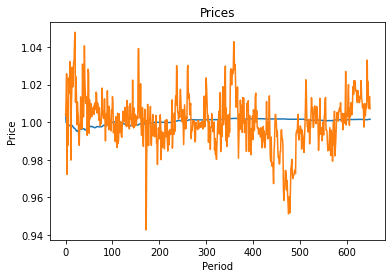

In [29]:
# Plot historical market price against expected price
plt.plot(p_exp[1:], label = "Expected Price")
plt.plot(mar_p[1:], label = "Market Price")
plt.title('Prices')
plt.xlabel('Period')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

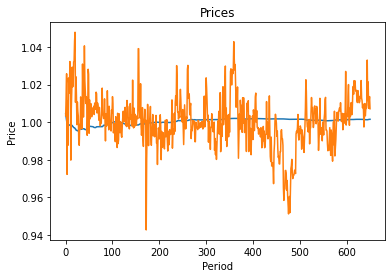

In [30]:
# Plot historical market price against modeled price
plt.plot(p_calc[1:], label = "Modeled Price")
plt.plot(mar_p[1:], label = "Market Price")
plt.title('Prices')
plt.xlabel('Period')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

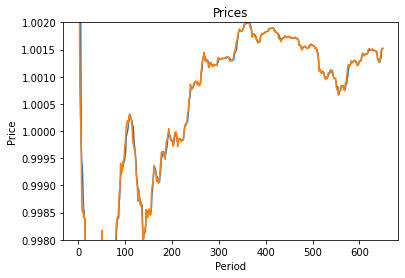

In [33]:
# Plot expected market price against modeled price
plt.plot(p_calc[1:], label = "Modeled Price")
plt.plot(p_exp[1:], label = "Expected Price")
plt.ylim((0.998, 1.002))
plt.title('Prices')
plt.xlabel('Period')
plt.ylabel('Price')